In [2]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def quickbarchart(serField):
    ser = hc[hc['SAMPLE_TYPE'] == "T"].groupby(serField).size().sort_values(ascending=False)
    ax = ser.plot(kind='bar', title ="Tumor sample count by "+serField,figsize=(15,3), fontsize=10)
    ax.set_xlabel(serField,fontsize=10)
    plt.show()

In [7]:
CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
CSV_FILENAME="healthCheckFile.csv"

hc = pd.read_csv(CSV_PATH + CSV_FILENAME)
# Clean Data + add custom fields
hc['SAMPLE_TYPE']=hc['SAMPLE'].str[12]
hc.replace(to_replace="", value="UNKNOWN", inplace=True)
hc.replace(to_replace="ERROR", value=0, inplace=True)
hc.replace(to_replace="-", value=0, inplace=True)
hc.replace(to_replace="v1.8-50-g2ddb75f", value="v1.9", inplace=True)
hc.fillna("Unknown", inplace=True)
if pd.isnull(hc['TUMOR_TYPE'].item):
    hc['TUMOR_TYPE'] = "Unknown"
hc['SOMATIC_SNP_COUNT_4+_CALLER'] = pd.to_numeric(hc['SOMATIC_SNP_COUNT'])*   \
    pd.to_numeric(hc['SOMATIC_SNP_PROPORTION_VARIANTS_4_CALLERS']) 
hc['SOMATIC_SNP_COUNT_3+_CALLER'] = pd.to_numeric(hc['SOMATIC_SNP_COUNT'])*   \
    pd.to_numeric(hc['SOMATIC_SNP_PROPORTION_VARIANTS_3_CALLERS']) + hc['SOMATIC_SNP_COUNT_4+_CALLER'] 
hc['SOMATIC_SNP_COUNT_2+_CALLER'] = pd.to_numeric(hc['SOMATIC_SNP_COUNT'])*   \
    pd.to_numeric(hc['SOMATIC_SNP_PROPORTION_VARIANTS_2_CALLERS']) + hc['SOMATIC_SNP_COUNT_3+_CALLER']
hc = hc.set_index('SAMPLE')
hc['SOMATIC_INDELS_COUNT_3+_CALLER'] = pd.to_numeric(hc['SOMATIC_INDELS_COUNT'])*   \
    pd.to_numeric(hc['SOMATIC_INDELS_PROPORTION_VARIANTS_3_CALLERS']) 
hc['SOMATIC_INDELS_COUNT_2+_CALLER'] = pd.to_numeric(hc['SOMATIC_INDELS_COUNT'])*   \
    pd.to_numeric(hc['SOMATIC_INDELS_PROPORTION_VARIANTS_2_CALLERS']) + hc['SOMATIC_INDELS_COUNT_3+_CALLER']   

hc =hc.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [8]:
len(hc[hc.HAS_PASSED_TESTS == False])

56

### Version and Tumor Type

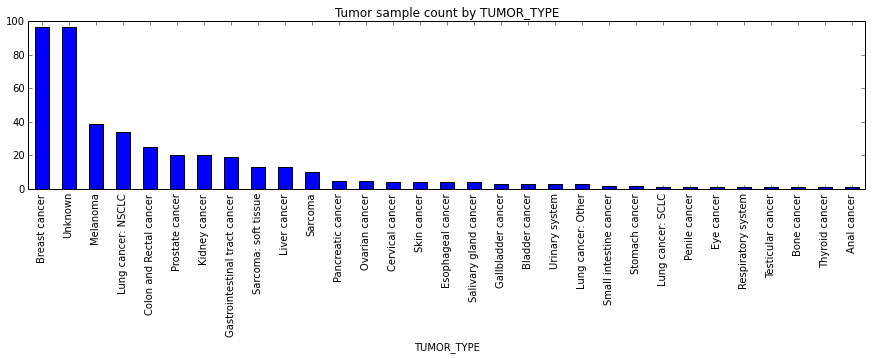

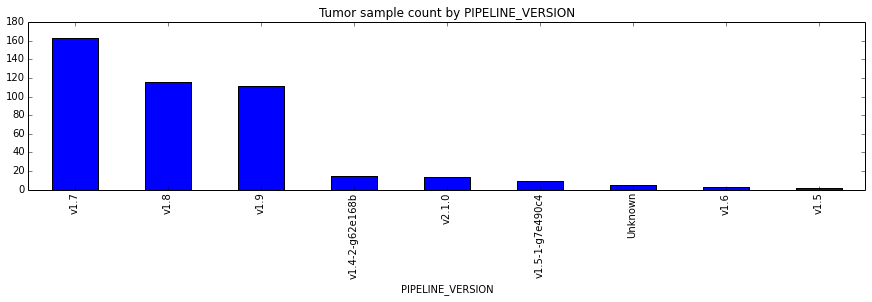

In [10]:
quickbarchart('TUMOR_TYPE')
quickbarchart('PIPELINE_VERSION')

### Total Somatic Counts

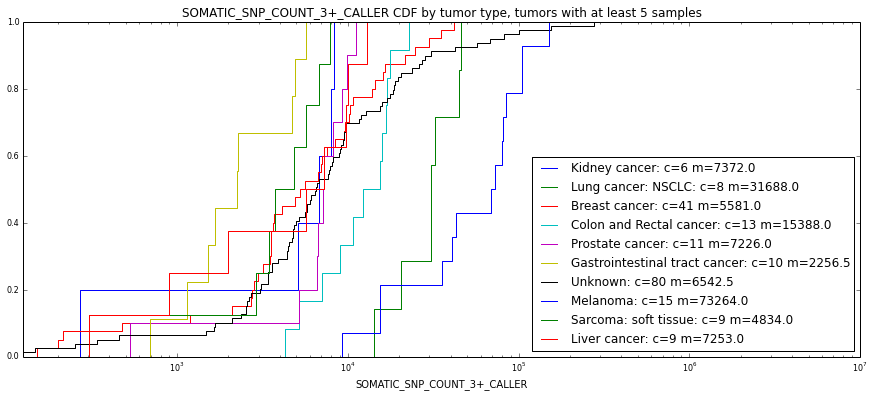

In [12]:
# BY TUMOR TYPE
minTypeCount = 5
tumorTypes = hc['TUMOR_TYPE'].unique()
analysisField = 'SOMATIC_SNP_COUNT_3+_CALLER'
versions = ['v1.8','v1.9'] #hc.PIPELINE_VERSION.unique()
types = ['T'] # hc["SAMPLE_TYPE"].unique()
for tumorType in tumorTypes:
    ser = hc[(hc.TUMOR_TYPE == tumorType) & hc.PIPELINE_VERSION.isin(versions) & hc.SAMPLE_TYPE.isin(types)][analysisField]
    if len(ser)>minTypeCount:
        try:
            #ser = pd.to_numeric(ser)
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name= str(tumorType)+": c="+str(ser.count())+" m="+str(round(ser.median(),4)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=analysisField+" CDF by tumor type, tumors with at least "+str(minTypeCount)+ " samples",\
                     figsize=[15,6],ylim=[0,1],xlim=[0,1E7],logx = True, fontsize=8)
        except:
            print "error in tumor type: "+ str(tumorType)

### Generic CDF

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:2536: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  + 'left=%s, right=%s') % (left, right))


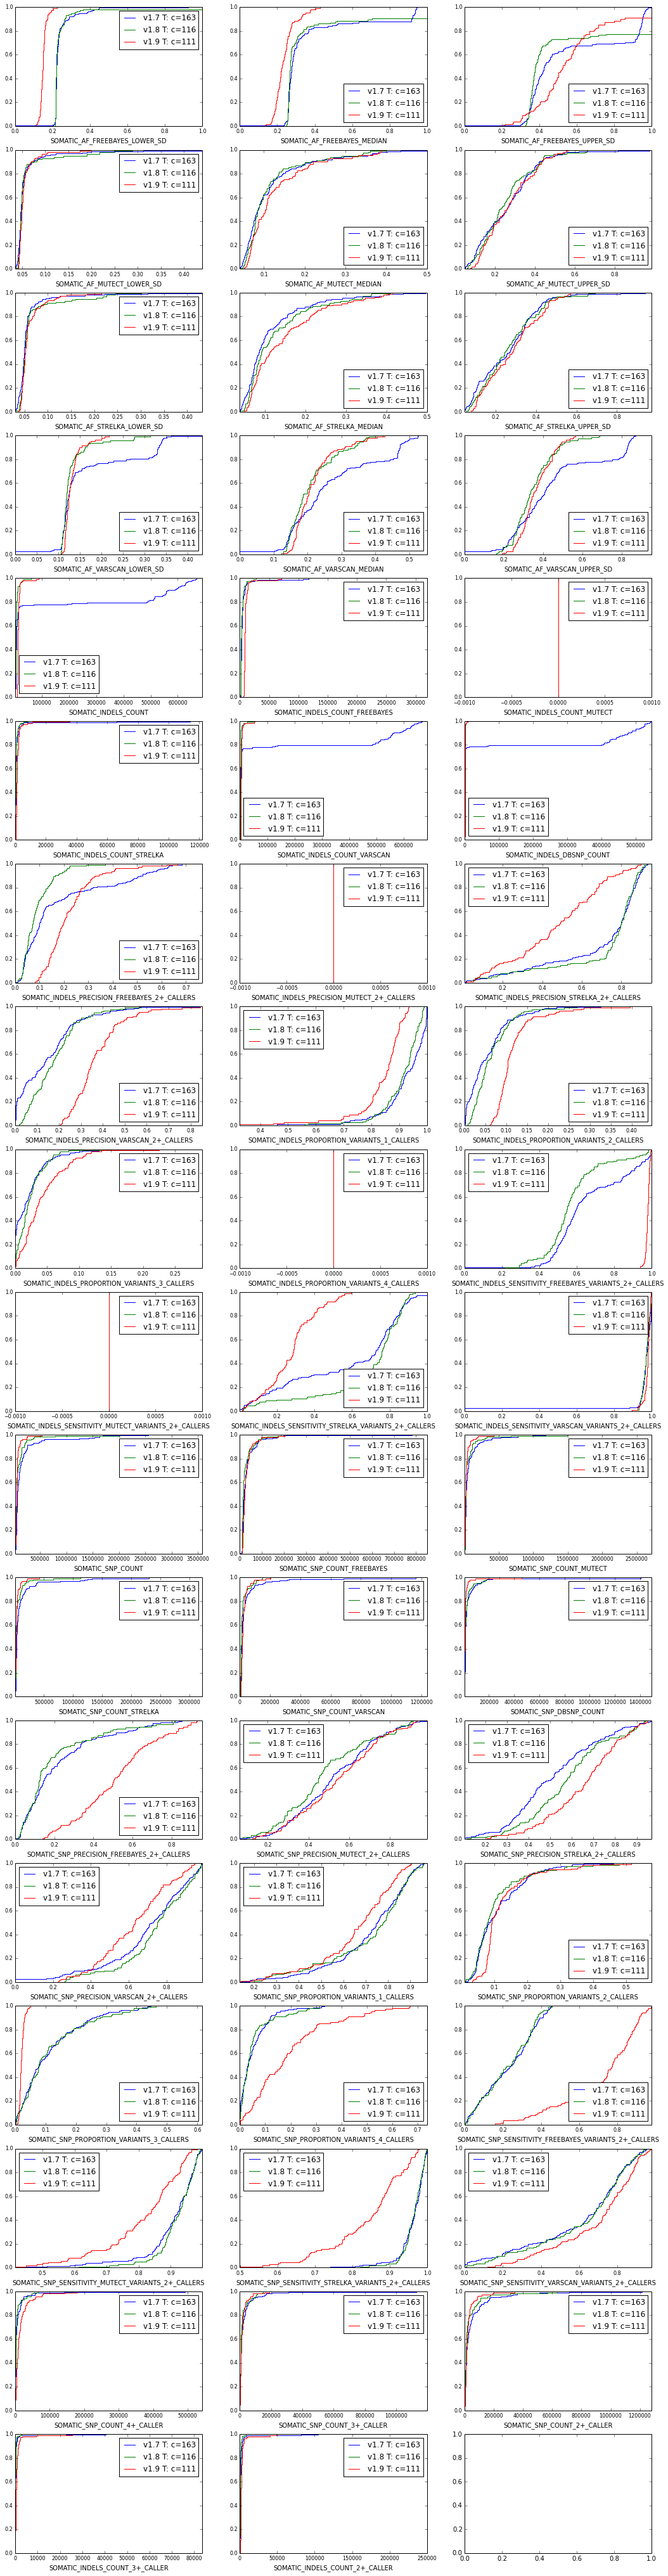

In [13]:
#SETTINGS
figsPerLine = 3
fieldFilter = "SOMATIC"
slicer = "PIPELINE_VERSION"
slicerFilters =['v1.7','v1.8','v1.9'] #hc[slicer].unique()
types = ['T'] # hc["SAMPLE_TYPE"].unique()

#CODE
analysisFields = list(hc.columns.values)
analysisFields = [x for x in analysisFields if fieldFilter in x]
numFigures = len(analysisFields)
fig, axs = plt.subplots(int(np.ceil(numFigures/figsPerLine)+1),figsPerLine)
i = -1
prevAnalysisField = ""
for analysisField in analysisFields:
    for slicerFilter in slicerFilters:
        for type in types:
            ser = hc[(hc[slicer] == slicerFilter) & (hc.SAMPLE_TYPE == type)][analysisField]
            try:
                ser = ser.sort_values()
                cum_dist = np.linspace(0.,1.,len(ser))
                ser_cdf = pd.Series(cum_dist, index=ser,name= str(slicerFilter)+" "+str(type) +": c="+str(ser.count()))
                if prevAnalysisField != analysisField:
                    i = i+1
                ser_cdf.plot(drawstyle='steps',legend=True,figsize=[18,4*(numFigures+1)/figsPerLine],ylim=[0,1],ax=axs[int(i/figsPerLine),i%figsPerLine],fontsize = 8)                
                prevAnalysisField = analysisField
            except:
                #pass        
                print  int(i/figsPerLine),i%figsPerLine,"error in field, version, type: "+ str(analysisField) + str(slicerFilter)+" "+ str(type)

### Scatter Plot

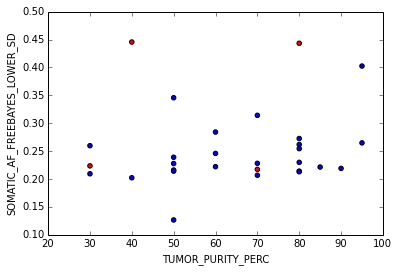

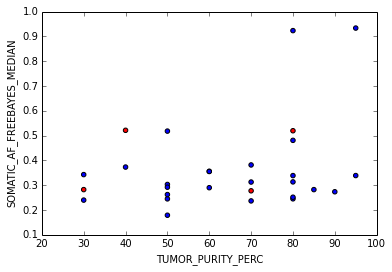

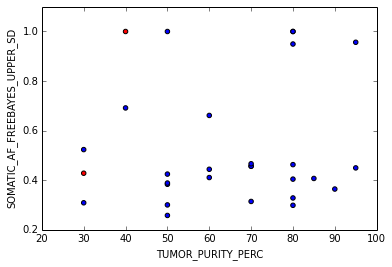

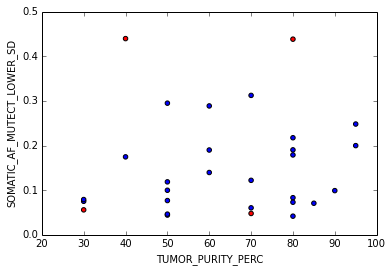

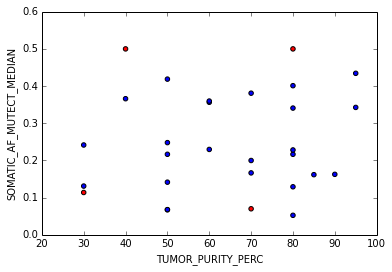

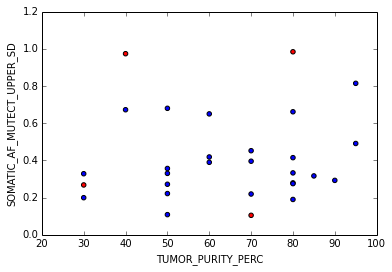

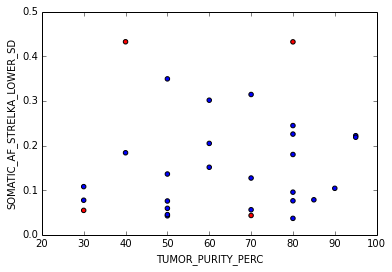

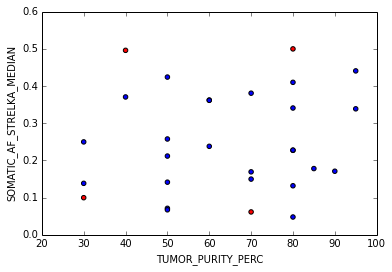

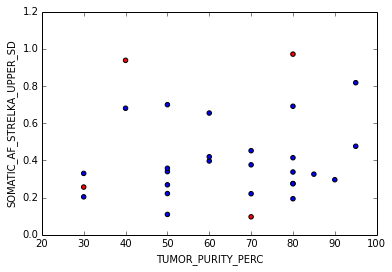

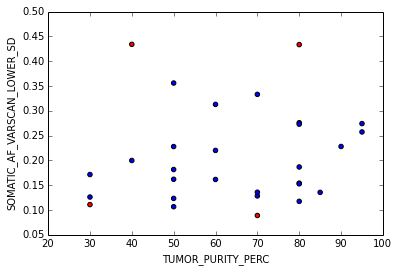

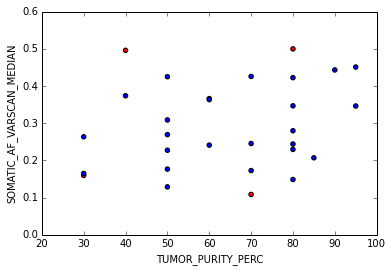

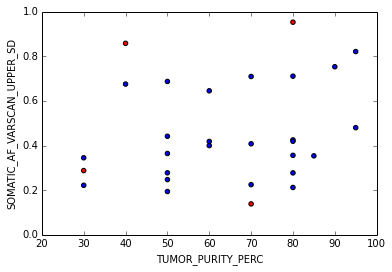

KeyboardInterrupt: 

In [8]:
fldX = 'TUMOR_PURITY_PERC'
fieldFilterY = 'AF'
dfTempFail = hc[(hc['SOMATIC_SNP_COUNT_3+_CALLER']>50000)&(hc.SAMPLE_TYPE=="T")& (hc.PIPELINE_VERSION.isin(['v1.7','v1.8','v1.9']))  & (hc.HAS_PASSED_TESTS == False)].apply(lambda x: pd.to_numeric(x, errors='coerce'))
dfTempPass = hc[(hc['SOMATIC_SNP_COUNT_3+_CALLER']>50000)&(hc.SAMPLE_TYPE=="T")& (hc.PIPELINE_VERSION.isin(['v1.7','v1.8','v1.9'])) & (hc.HAS_PASSED_TESTS == True)].apply(lambda x: pd.to_numeric(x, errors='coerce'))
analysisFields = list(hc.columns.values)
analysisFields = [x for x in analysisFields if fieldFilterY in x]
for fldY in analysisFields:
    ax = dfTempFail.plot(kind='scatter',color='Red', x=fldX, y=fldY)
    dfTempPass.plot(kind='scatter', x=fldX, y=fldY,ax=ax)


### SAMPLE ANALYSER

In [14]:
analysisSample = 'CPCT02020219T'
hcQuantile = hc[hc.SAMPLE_TYPE=="T"].rank(axis=0, method='average', numeric_only=True, na_option='keep', ascending=True, pct=True)
hcSummary = hc.loc[analysisSample].to_frame().join(hcQuantile.loc[analysisSample].to_frame().rename(columns={analysisSample: 'quantile'}),rsuffix='_q').sort_values('quantile')
hcSummary['quantile'] = (100*hcSummary['quantile']).map('{0:.0f}%'.format).replace(to_replace="nan%", value="")
hcSummary[hcSummary['quantile'] != '']

,CPCT02020219T,quantile
MAPPING_MEDIAN_INSERT_SIZE,348,3%
MAPPING_WIDTH_OF_70_PERCENT,189,5%
SOMATIC_INDELS_PROPORTION_VARIANTS_2_CALLERS,0.0019851,6%
SOMATIC_INDELS_PRECISION_VARSCAN_2+_CALLERS,0.00226538,7%
COPYNUMBER_GENOME_GAIN,77290098,9%
SOMATIC_AF_FREEBAYES_UPPER_SD,0.340206,9%
COPYNUMBER_GENOME_LOSS,69974440,13%
SOMATIC_SNP_PROPORTION_VARIANTS_2_CALLERS,0.0467894,14%
SOMATIC_SNP_COUNT,38684,14%
MAPPING_PERCENTAGE_MAPPED,0.987934,16%
